<div class="alert alert-vlock alert-info"> A tutorial: How to predict customer response to marketing campaigns </div>

The goal is to build a classification model that can predict a customer's response to a specific advertising campaign based on basic customer information for instance gender, age, and income. 

The model would be able to state for example do not target customers with an income below 50,000 with ad campaign 2.

The goal is to

build logistic regression and Support Vector Machine (SVM) models
rebalance imbalanced data
evaluate and visualize model performance through different measures
use performance metrices to compare alternative models

<div class="alert alert-vlock alert-info"> Importing libraries </div>

In [1]:
import pandas as pd
import numpy as np
import itertools


import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick
import scikitplot as skplt 

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from collections import Counter

<div class="alert alert-vlock alert-info"> Importing data </div>

In [2]:
data = pd.read_csv('CustomerResponseData.csv')
data.head(10).style 

,customer_id,campaign,response,response_date,purchase,purchase_date,product_id,Rowid,age,age_youngest_child,average#balance#feed#index,branch,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,marital,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
0,7,2,0,,0,,,1,19,0,0,Ravensville,19,M,0,0,0,64,13362,S,2,-4,0,1,1,1,0,9,26,0.000000,3
1,13,2,0,,0,,,2,44,12,0,Catburg,44,M,0,0,0,65,13453,S,2,17,24,0,0,0,0,14,19,0.000000,1
2,15,2,0,,0,,,3,45,12,75,Ravensville,45,F,0,0,0,65,13453,U,2,33,36,0,4,2,1,14,19,7.602330,1
3,16,2,1,7/5/2006 0:00:00,0,,183,761,43,12,161,Catburg,43,F,0,0,0,65,13453,U,2,34,36,0,0,3,2,14,19,10.143000,1
4,23,2,0,,0,,,4,42,11,0,Kingsville,42,F,0,0,0,65,13453,M,2,22,24,0,0,0,0,14,19,0.000000,3
5,24,2,0,,0,,,5,39,7,521,Princeton,39,F,0,0,0,65,13453,S,2,26,36,0,0,0,3,14,19,9.854320,2
6,30,2,0,,0,,,6,23,0,0,Princeton,23,F,0,0,0,65,13453,S,2,30,36,0,1,0,0,14,19,0.000000,1
7,30,3,0,,0,,,7,23,0,0,Princeton,23,F,0,0,0,65,13453,S,2,30,36,0,1,0,0,14,19,0.000000,1
8,33,2,0,,0,,,8,24,0,0,Foxton,24,M,0,0,0,65,13453,S,2,-2,0,0,0,0,0,14,19,0.000000,1
9,42,3,0,,0,,,9,35,8,0,Queensbury,35,M,0,0,0,65,13453,M,2,22,24,0,1,0,0,14,19,0.000000,3


In [3]:
data.shape

(21927, 31)

In [4]:
keys, counts = np.unique(data.campaign, return_counts=True)
for k, c in zip(keys, counts): 
    print("campaign: " + str(k) + " count: " + str(c))

campaign: 1 count: 1747
campaign: 2 count: 13504
campaign: 3 count: 5285
campaign: 4 count: 1391


<div class="alert alert-vlock alert-info"> Choosing campaign 2 </div>

In [5]:
data2 = data[data['campaign']==2]
data2.shape

(13504, 31)

In [6]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13504 entries, 0 to 21926
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     13504 non-null  int64  
 1   campaign                        13504 non-null  int64  
 2   response                        13504 non-null  int64  
 3   response_date                   13504 non-null  object 
 4   purchase                        13504 non-null  int64  
 5   purchase_date                   13504 non-null  object 
 6   product_id                      13504 non-null  object 
 7   Rowid                           13504 non-null  int64  
 8   age                             13504 non-null  int64  
 9   age_youngest_child              13504 non-null  int64  
 10  average#balance#feed#index      13504 non-null  int64  
 11  branch                          13504 non-null  object 
 12  debt_equity                     

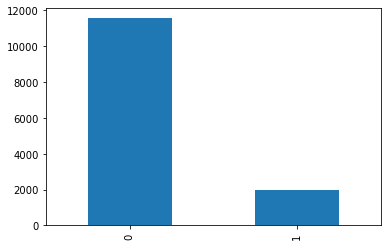

In [7]:
ax = data2['response'].value_counts().plot(kind='bar')

<div class="alert alert-vlock alert-info"> Let's plot the decision to buy, no response rate 85.5.% </div>

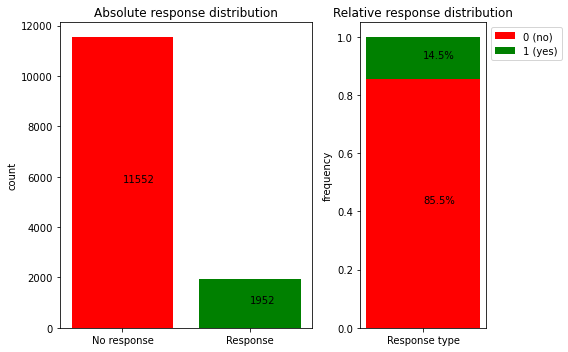

In [45]:
keys, counts = np.unique(data2.response, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1]) 

ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No response', 'Response'], counts, color=['#FF0000','#008000']) 
ax0 = plt.title('Absolute response distribution') 
ax0 = plt.ylabel('count')
ax0 = plt.text(keys[0], counts[0]/2, counts[0]) 
ax0 = plt.text(keys[1], counts[1]/2, counts[1]) 

ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Response type'], [counts_norm[0]], color=['#FF0000'], label='0 (no)')
ax1 = plt.bar(['Response type'], [counts_norm[1]], color=['#008000'], bottom=counts_norm[0], label='1 (yes)')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative response distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Response type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Response type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.savefig("absoluteresponsedistribution.png", bbox_inches='tight')
plt.show()

<div class="alert alert-vlock alert-info"> Let's plot and use the gender </div>

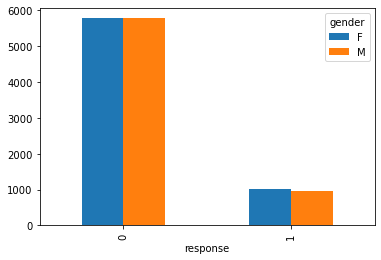

In [9]:
ax = data2.groupby(['response', 'gender'])['gender'].count().unstack().plot.bar()

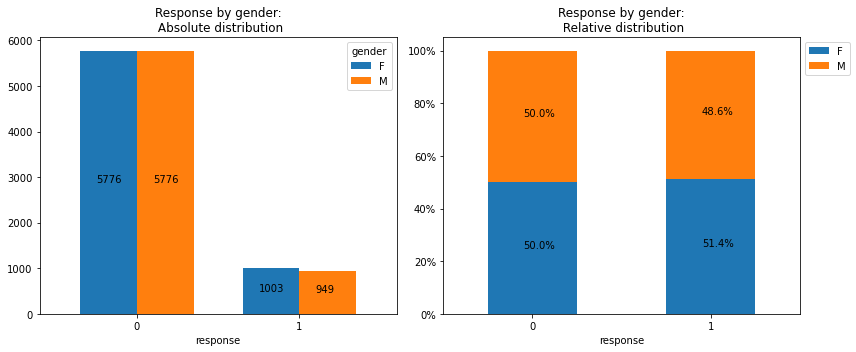

In [46]:
fig = plt.figure(figsize=(12, 5)) 

plt.subplot(1, 2, 1)
ax1 = data2.groupby(['response', 'gender'])['gender'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by gender:\n Absolute distribution') 

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))


plt.subplot(1, 2, 2)
ax2 = data2.groupby(['response','gender'])['gender'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Response by gender:\n Relative distribution') 

for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.savefig("responsebygender.png", bbox_inches='tight')
plt.show()

<div class="alert alert-vlock alert-info"> Let's plot and use the relative income, we can observe that the campaign is effective over income 55 000 EUR </div>

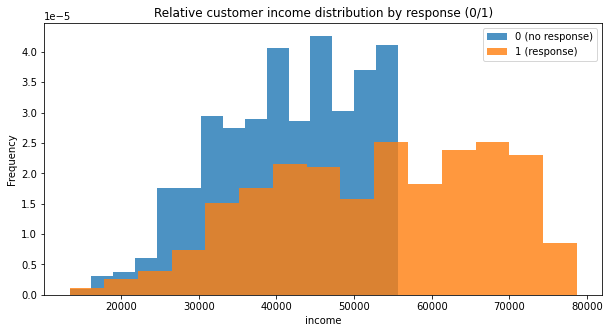

In [47]:
ax = data2['income'].loc[data2['response'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='0 (no response)', figsize = (10,5))
ax = data2['income'].loc[data2['response'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='1 (response)', figsize = (10,5))
ax.set_xlabel('income')
ax.set_title('Relative customer income distribution by response (0/1)')
plt.savefig("relativecustomerincomedistribution.png", bbox_inches='tight')
ax.legend();

<div class="alert alert-vlock alert-info"> Let's plot and we can see that there is no difference between gender </div>

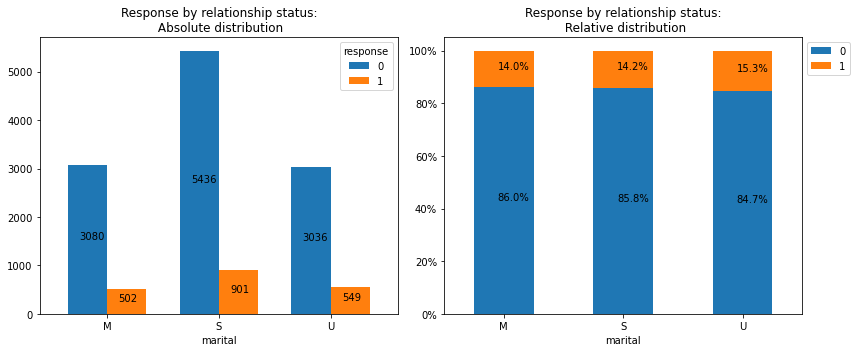

In [48]:
fig = plt.figure(figsize=(12, 5)) 


plt.subplot(1, 2, 1)
ax1 = data2.groupby(['marital', 'response'])['response'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by relationship status:\n Absolute distribution') 

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))


plt.subplot(1, 2, 2)
ax2 = data2.groupby(['marital','response'])['response'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Response by relationship status:\n Relative distribution') 

for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.savefig("differencebetweeengender.png", bbox_inches='tight')
plt.show()

<div class="alert alert-vlock alert-info"> Let's plot and we can see that there is high RFM customers who are responsive to the campaign</div>

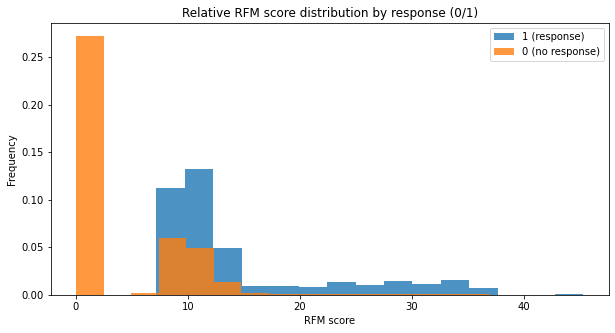

In [49]:
ax = data2['rfm_score'].loc[data2['response'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='1 (response)', figsize = (10,5))
ax = data2['rfm_score'].loc[data2['response'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='0 (no response)', figsize = (10,5))
ax.set_xlabel('RFM score')
ax.set_title('Relative RFM score distribution by response (0/1)')
plt.savefig("relativerfmsocre.png", bbox_inches='tight')
ax.legend();

<div class="alert alert-vlock alert-info"> Let's choose the variables</div>

In [15]:
X, y = data2[['gender', 'income', 'marital', 'rfm_score']], data2['response'] 
X.head()

,gender,income,marital,rfm_score
0,M,13362,S,0.00000
1,M,13453,S,0.00000
2,F,13453,U,7.60233
3,F,13453,U,10.14300
4,F,13453,M,0.00000


<div class="alert alert-vlock alert-info"> Recoding</div>

In [16]:
X = pd.get_dummies(X, columns=["gender", "marital"], prefix=["gender", "marital"])
X.head()

,income,rfm_score,gender_F,gender_M,marital_M,marital_S,marital_U
0,13362,0.00000,0,1,0,1,0
1,13453,0.00000,0,1,0,1,0
2,13453,7.60233,1,0,0,0,1
3,13453,10.14300,1,0,0,0,1
4,13453,0.00000,1,0,1,0,0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

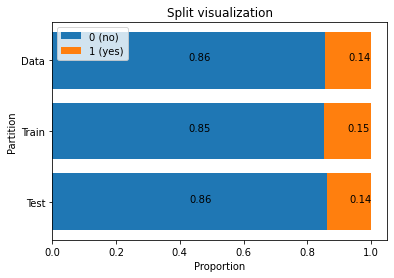

In [18]:
train_dist = y_train.value_counts() / len(y_train) 
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

In [19]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [20]:
def plot_2d_space(X, y, label='Classes', title='x', xlabel='x', ylabel='y'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=2
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')

Original label Counter({0: 8063, 1: 1389})
SMOTE label Counter({0: 8063, 1: 8063})


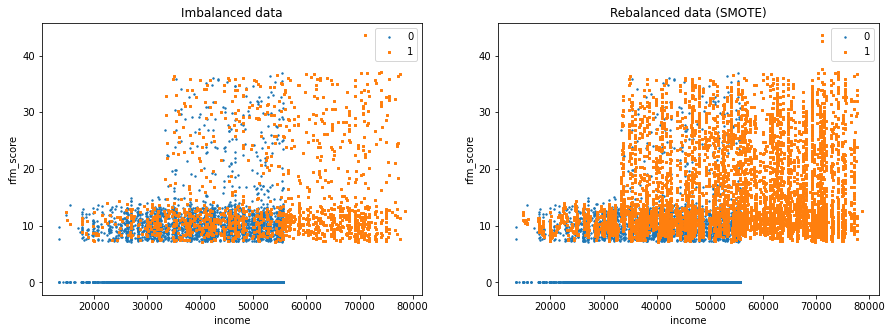

In [21]:
print('Original label %s' % Counter(y_train))
print('SMOTE label %s' % Counter(y_sm))

fig = plt.figure(figsize=(15, 5)) 

ax0 = plt.subplot(121)
ax0 = plot_2d_space(np.array(X_train), y_train, title='Imbalanced data', xlabel='income', ylabel='rfm_score')

ax1 = plt.subplot(122)
ax1 = plot_2d_space(np.array(X_sm), y_sm, title='Rebalanced data (SMOTE)', xlabel='income', ylabel='rfm_score')

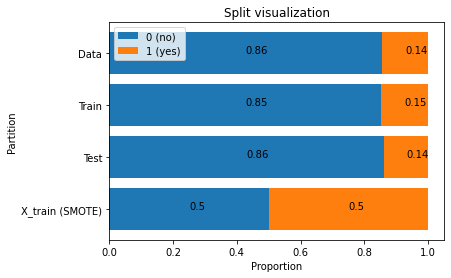

In [22]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['X_train (SMOTE)', 'Test', 'Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

<div class="alert alert-vlock alert-info"> Model building </div>
<div class="alert alert-vlock alert-info"> SVM </div>

In [24]:
svm_imb = SVC(gamma='auto', kernel='rbf') 
svm_imb.fit(X_train, y_train) 

SVC(gamma='auto')

In [25]:
y_pred_svm_imb = svm_imb.predict(X_test)

In [26]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_svm_imb)*100).round(2))

Accuracy is:  86.15


<div class="alert alert-vlock alert-info"> Balanced data </div>

In [27]:
svm_bal = SVC(gamma='auto', kernel='rbf') #define SVM classifier 
svm_bal.fit(X_sm, y_sm) #fit SVM model to the SMOTE training data

SVC(gamma='auto')

In [28]:
y_pred_svm_bal = svm_bal.predict(X_test) 

In [29]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_svm_bal)*100).round(2))

Accuracy is:  82.45


In [30]:
svm_bal_proba = SVC(gamma='auto', probability=True)
svm_bal_proba.fit(X_sm, y_sm)

SVC(gamma='auto', probability=True)

In [31]:
y_predProba_svm_bal = svm_bal_proba.predict_proba(X_test)

<div class="alert alert-vlock alert-info"> Logistic regression</div>

In [32]:
# Logistic Regression
lr_bal = LogisticRegression(random_state=42, solver='lbfgs') #define Logistic Regression classifier
lr_bal.fit(X_sm, y_sm) #fit LR model to the balanced SMOTE training data

LogisticRegression(random_state=42)

In [33]:
y_pred_lr_bal = lr_bal.predict(X_test)

In [34]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_bal)*100).round(2))

Accuracy is:  69.72


In [35]:
y_predProba_lr = lr_bal.predict_proba(X_test)

<div class="alert alert-vlock alert-info"> Model evaluation</div>
<div class="alert alert-vlock alert-info"> Confusion Matrix</div>
<div class="alert alert-vlock alert-info"> AUC</div>
<div class="alert alert-vlock alert-info"> Gains chart</div>
<div class="alert alert-vlock alert-info"> Lift chart</div>

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<div class="alert alert-vlock alert-info">  Confusion matrix</div>

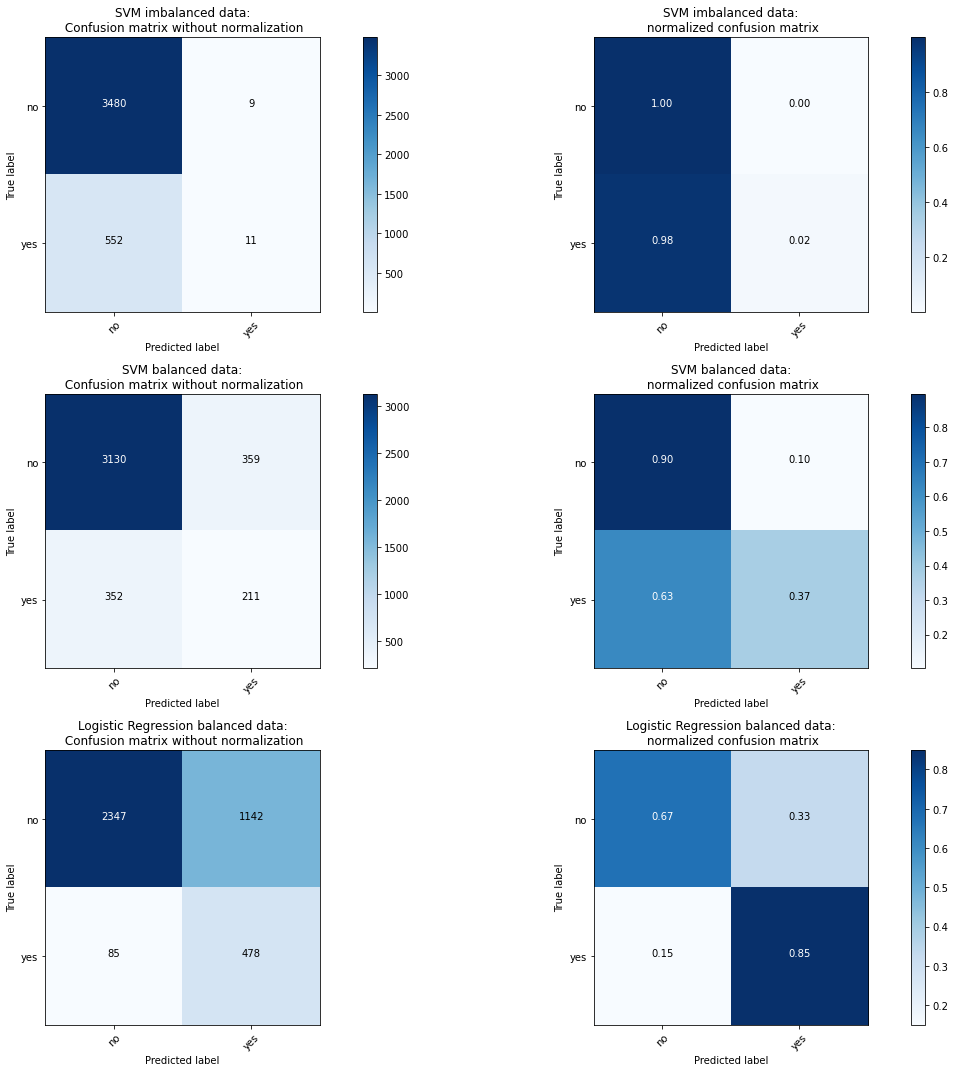

In [38]:
# Compute confusion matrix
class_names = ['no', 'yes']
cnf_matrix_imb = confusion_matrix(y_test, y_pred_svm_imb)
cnf_matrix_bal = confusion_matrix(y_test, y_pred_svm_bal)
cnf_matrix_lr = confusion_matrix(y_test, y_pred_lr_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot SVM imbalanced confusion matrix
plt.subplot(321) 
plot_confusion_matrix(cnf_matrix_imb, classes=class_names,
                      title='SVM imbalanced data:\n Confusion matrix without normalization')

#Plot SVM imbalanced normalized confusion matrix
plt.subplot(322)
plot_confusion_matrix(cnf_matrix_imb, classes=class_names, normalize=True,
                      title='SVM imbalanced data:\n normalized confusion matrix')

#Plot SVM balanced confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_bal, classes=class_names,
                      title='SVM balanced data:\n Confusion matrix without normalization')

#Plot SVM balanced normalized confusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_bal, classes=class_names, normalize=True,
                      title='SVM balanced data:\n normalized confusion matrix')

#Plot Logistic Regression (balanced) confusion matrix
plt.subplot(325) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names,
                      title='Logistic Regression balanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (balanced) normalized onfusion matrix
plt.subplot(326) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names, normalize=True,
                      title='Logistic Regression balanced data:\n normalized confusion matrix')

plt.show()

The confusion matrix tells the following thing:
    
How the unbalanced SVM classifier is predicting the majority class "0, no". The highly imbalanced class distribution is the reason why this strategy results in the highest testing accuracy of >86%. 

If the data has >85% "no" observations then always predicting "no" will result in about 85% correct "predictions". 

However, such a classifier has clearly not learned anything and is utterly useless in practice.

The balanced SVM classifier performs well: while it "only" identifies 90% of the "no" cases correctly, it is able to get 38% of the "yes" cases right.

The balanced Logistic Regression classifier gets 67% "no" and 85% "yes" cases right. This is an interesting observations as the model performs better on the minority class.

<div class="alert alert-vlock alert-info"> AUC and ROC</div>

The area under the curve  is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. 

The chart below shows how the unbalanced SVM classifier is no better than a random guess (blue line almost equal to dotted black line). 

In contrast, training a SVM and Logistic Regression classifier on the balanced data leads to significant performance improvements.

Note how the Logistic Regression runs mostly above the SVM curve, but not always.

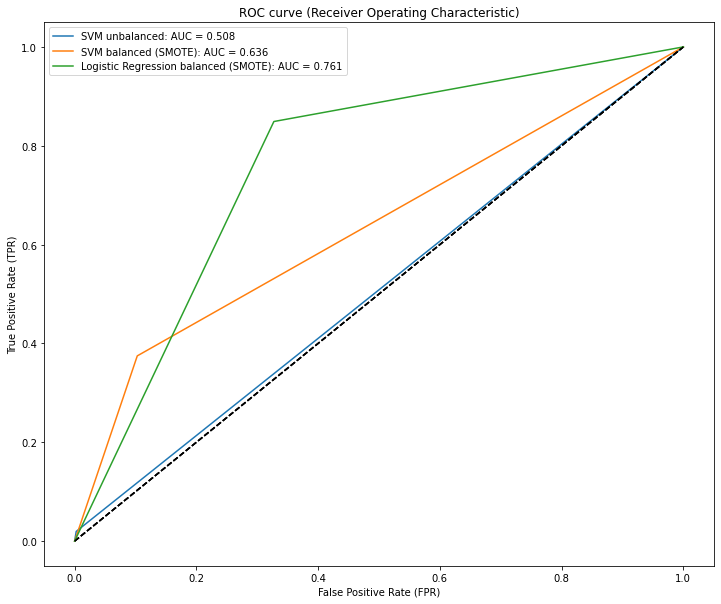

In [40]:
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test, y_test], [y_pred_svm_imb, y_pred_svm_bal, y_pred_lr_bal], range(1,4), ['SVM unbalanced', 'SVM balanced (SMOTE)', 'Logistic Regression balanced (SMOTE)']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

<div class="alert alert-vlock alert-info"> Cumulative Response Curve, aka. Gains chart</div>

A Gain chart plots the gain (percentage of positives correctly classified by model; tp rate; hit rate) as a function of the percentage of the population that is targeted (decreasing by score).

The diagonal x=y represents a random classifier; any classifier that is above the diagonal is providing some advantage.

A wide gap between a random classifier (baseline) and a model indicates a high performance advantage in using said model.

The cumulative gains graph can be used to estimate how many customers one should address to make a certain profit. Indeed, the cumulative gains graph shows which percentage of all targets is reached when addressing a certain percentage of the population.

In order to get a 80% True Positive hit rate, we would need to target ca. 30% of the population with the SVM model, and ca. 40% with the Logistic Regression model. 

The SVM model shows some "sweet spot" around 75% gain after which the curve becomes flatter.

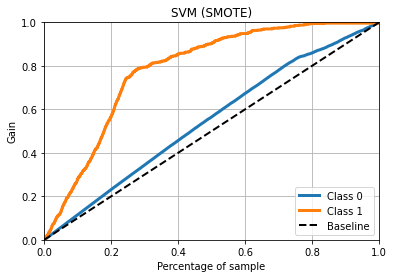

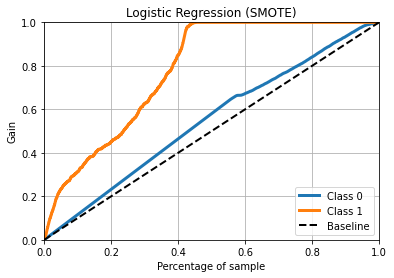

In [42]:
# Cumulative Response Curve, aka. Gains chart
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_svm_bal, title='SVM (SMOTE)')
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_lr, title='Logistic Regression (SMOTE)');

<div class="alert alert-vlock alert-info"> Lift - How much better is the model compared to a random classifier?</div>

From DSB I slides:

Lift ~ advantage of a classifier over random guessing.

Represents the degree to which the model “pushes up” positive instance in a list above the negative instances.

Lift curve ~ value of cumulative response curve at a given point x divided by the diagonal line (y=x) value at that point.

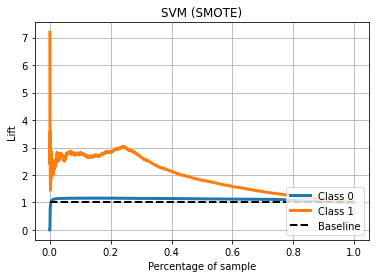

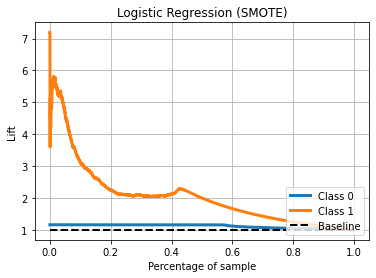

In [44]:
# Lift - How much better is the model compared to a random classifier?
skplt.metrics.plot_lift_curve(y_test, y_predProba_svm_bal, title='SVM (SMOTE)')
skplt.metrics.plot_lift_curve(y_test, y_predProba_lr, title='Logistic Regression (SMOTE)');

Which model is the best

Rebalancing clearly improves the models' performance.

Still unclear Whether to choose SVM or Logistic Regression.